# Generating surrogate distributions

In this activity we will generate surrogate distributions to assess the statistical significance of estimates from several different estimator types, and examine their properties.   

Start by opening the MI AutoAnalyser. 
Select a Gaussian estimator, data file 2CoupledRandomCols-1.txt and click the checkbox next to Add stat signif.?. Click Generate Code and Compute.

Use the code generated but replace source and destination with random normal data.

In [1]:
from jpype import startJVM, getDefaultJVMPath, JArray, JDouble, JInt, JPackage, shutdownJVM, isJVMStarted
import numpy as np
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/home/jovyan/notebooks/jidt/demos/python")
import readIntsFile

# Add JIDT jar library to the path
jarLocation = "/home/jovyan/notebooks/jidt/infodynamics.jar"
# Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
if (not isJVMStarted()):
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)

## setup source and destination data

In [2]:
# source and destination data 

N=100 #number fo samples
S=1000 #number of surrogates to generate

source = np.random.normal(size=N)  # assign random normal data to source with mean 0 and std 1
coupling = 0; # We'll change this later
destination = np.random.normal(size=N) # assign random normal data to destination
source.shape

(100,)

In [3]:
# Conversion to Java double array instead of numpy.float
source = JArray(JDouble, 1)(source.tolist())
destination = JArray(JDouble, 1)(destination.tolist())

In [4]:
# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.gaussian").MutualInfoCalculatorMultiVariateGaussian
calc = calcClass()
# 2. Set any properties to non-default values:
# No properties were set to non-default values
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()
# 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
measDist = calc.computeSignificance(S)


In [5]:
print("MI_Gaussian(col_0 -> col_1) = %.4f nats (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %
    (result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, S))

MI_Gaussian(col_0 -> col_1) = 0.0002 nats (null: 0.0050 +/- 0.0069 std dev.; p(surrogate > measured)=0.81600 from 1000 surrogates)


In [6]:
distribution = np.array(measDist.distribution)
distribution.shape

(1000,)

In [7]:
surrogates_hist, hist_edges = np.histogram(distribution, bins=50)
hist_edges.shape

(51,)

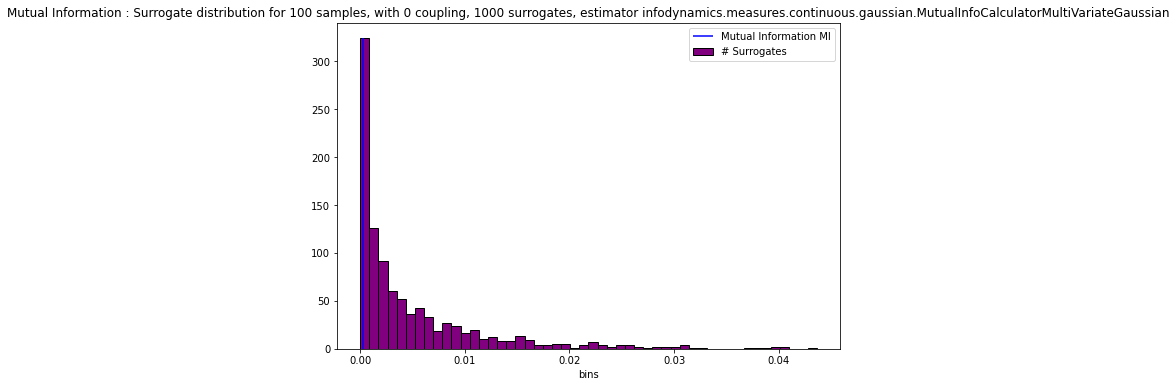

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(9, 6))  
#axs.plot([t for t in range(50)], surrogates_hist, label='# Surrogates')
axs.bar(x=hist_edges[:-1], height=surrogates_hist, width=np.diff(hist_edges), align='edge',fc='purple', ec='black', label='# Surrogates')
axs.vlines(x=result, ymin=0, ymax=np.max(surrogates_hist), colors='blue', label='Mutual Information MI' )

calcName=calcClass.__name__

axs.set_title('Mutual Information : Surrogate distribution for {} samples, with {} coupling, {} surrogates, estimator {}'.format(N, coupling, S, calcName))
axs.set_xlabel('bins')
plt.legend()
plt.show()

### 10.

Note the scale of the x axis of the surrogate distribution (you could save the plot to compare to later).   
Now change the number of samples N in your code to be 10 times larger.   
How do you expect the surrogate distribution to change when it is based on more samples, and why?    

 -- If we change the number of samples N, I don't expect the surrogate distribution to change much.

Run the code and notice how the surrogate distribution changes.   
Did this match your expectation?

In [9]:
# source and destination data 

N=1000 #number of samples
S=1000 #number of surrogates to generate

source = np.random.normal(size=N)  # assign random normal data to source with mean 0 and std 1
coupling = 0; # We'll change this later
destination = np.random.normal(size=N) # assign random normal data to destination
source.shape

# Conversion to Java double array instead of numpy.float
source = JArray(JDouble, 1)(source.tolist())
destination = JArray(JDouble, 1)(destination.tolist())

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.gaussian").MutualInfoCalculatorMultiVariateGaussian
calc = calcClass()
# 2. Set any properties to non-default values:
# No properties were set to non-default values
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result2 = calc.computeAverageLocalOfObservations()
# 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
measDist = calc.computeSignificance(S)


# Building histogram

distribution = np.array(measDist.distribution)
surrogates_hist2, hist_edges2 = np.histogram(distribution, bins=50)

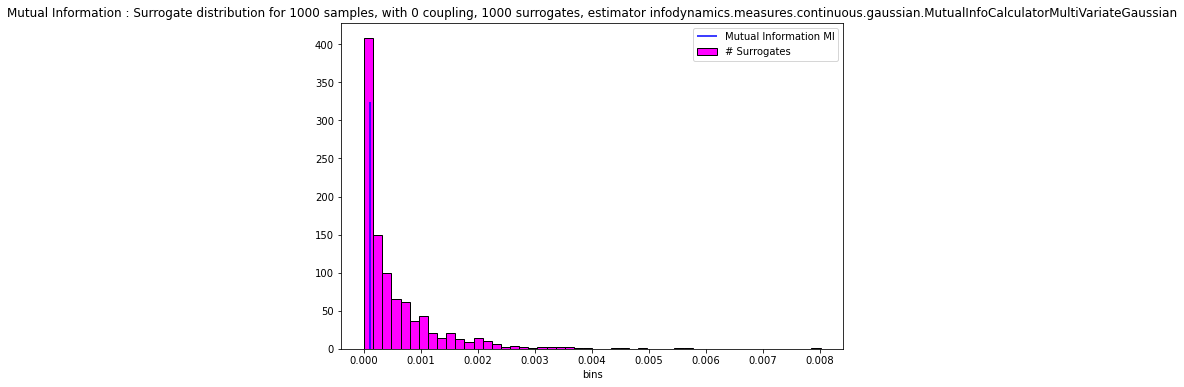

In [10]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(9, 6))  
#axs.plot([t for t in range(50)], surrogates_hist, label='# Surrogates')
axs.bar(x=hist_edges2[:-1], height=surrogates_hist2, width=np.diff(hist_edges2), align='edge',fc='magenta', ec='black', label='# Surrogates')
axs.vlines(x=result2, ymin=0, ymax=np.max(surrogates_hist), colors='blue', label='Mutual Information MI' )

calcName=calcClass.__name__

axs.set_title('Mutual Information : Surrogate distribution for {} samples, with {} coupling, {} surrogates, estimator {}'.format(N, coupling, S, calcName))
axs.set_xlabel('bins')
plt.legend()
plt.show()

### 11 Add Coupling

Our work so far has dealt with measuring an MI between independent source and destination.    
Let's introduce a dependence -- this will not change the surrogate distribution, but may change the statistical significance of the measurement.    

In [11]:
def setupData(N, S, coupling):
    # source and destination data 
    # N : number of samples
    # S : number of surrogates
    # coupling : coupling between the 2 variables

    source = np.random.normal(size=N)  # assign random normal data to source with mean 0 and std 1
    destination = coupling * source + (1 - coupling) * np.random.normal(size=N) # assign random normal data to destination

    # Conversion to Java double array instead of numpy.float
    source = JArray(JDouble, 1)(source.tolist())
    destination = JArray(JDouble, 1)(destination.tolist())
    return source, destination

In [12]:
def calcGaussianMI(source, destination):
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.continuous.gaussian").MutualInfoCalculatorMultiVariateGaussian
    calc = calcClass()
    # 2. Set any properties to non-default values:
    # No properties were set to non-default values
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.setObservations(source, destination)
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    # 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
    measDist = calc.computeSignificance(S)


    # Building histogram

    distribution = np.array(measDist.distribution)
    return result, calc, calcClass, distribution

In [13]:
def plotHist(distribution, result, barcolor, calcName):

    # Building histogram

    surrogates_hist, hist_edges = np.histogram(distribution, bins=50)

    fig, axs = plt.subplots(1, 1, figsize=(9, 6))  

    axs.bar(x=hist_edges[:-1], height=surrogates_hist, width=np.diff(hist_edges), align='edge',fc=barcolor, ec='black', label='# Surrogates')
    axs.vlines(x=result, ymin=0, ymax=np.max(surrogates_hist), colors='blue', label='Mutual Information MI' )

    #calcName=calcClass.__name__

    axs.set_title('Mutual Information : Surrogate distribution for {} samples, with {} coupling, {} surrogates, estimator {}'.format(N, coupling, S, calcName))
    axs.set_xlabel('bins edges')
    plt.legend()
    plt.show()

Mutual Information calculated:0.000399


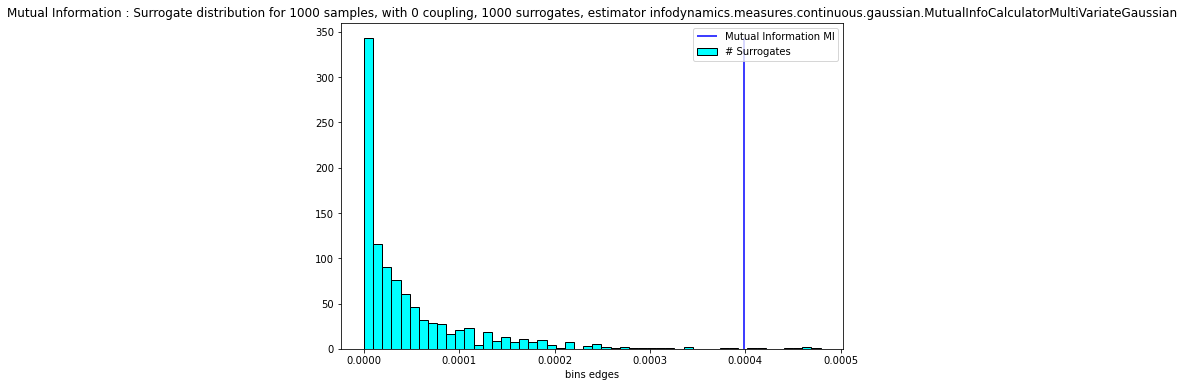

In [14]:
source, destination = setupData(10000, 10000, 0.01)
result3, calc3, calcClass3, distribution3 = calcGaussianMI(source, destination)

print('Mutual Information calculated:{:.6f}'.format(result3) )

plotHist(distribution3, result3, 'cyan', calcClass3.__name__)

### 13. Turn up coupling     

Let's turn up the coupling variable to 0.05 make the effect stronger and see if we can detect the dependence.   
Does that help or is it still too small to detect, given the number of samples that we have? 

#### Answer:

Try using more samples (set N = 10000;) -- does this make it easier to discern the dependence effect from background noise? Why? 

#### Answer: 

What factors have you now observed to help or hinder us to detect dependence between variables from empirical data?

#### Answer: 
Best to detect relationship:
x more samples
x stronger relationship

Mutual Information calculated:0.001002


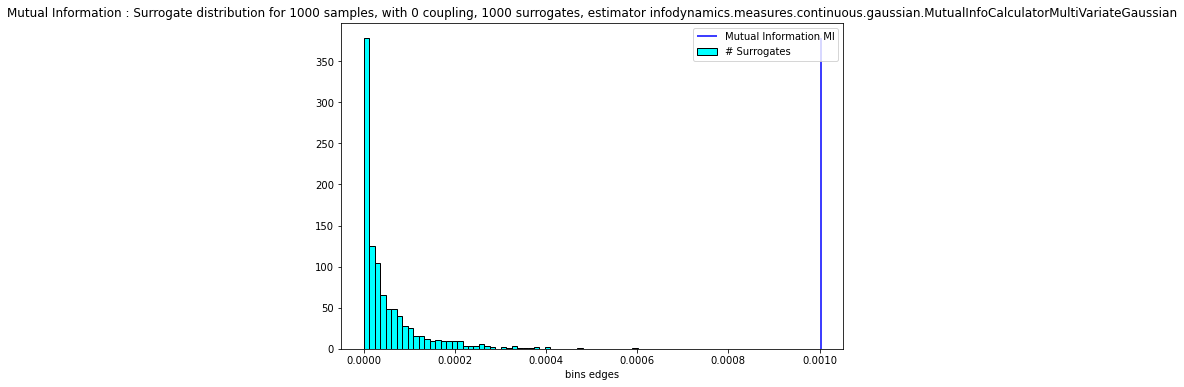

In [15]:
source, destination = setupData(10000, 10000, 0.05)
result4, calc4, calcClass4, distribution4 = calcGaussianMI(source, destination)

print('Mutual Information calculated:{:.6f}'.format(result4) )

plotHist(distribution4, result4, 'cyan', calcClass4.__name__)

(1000,)
Mutual Information calculated:0.003223


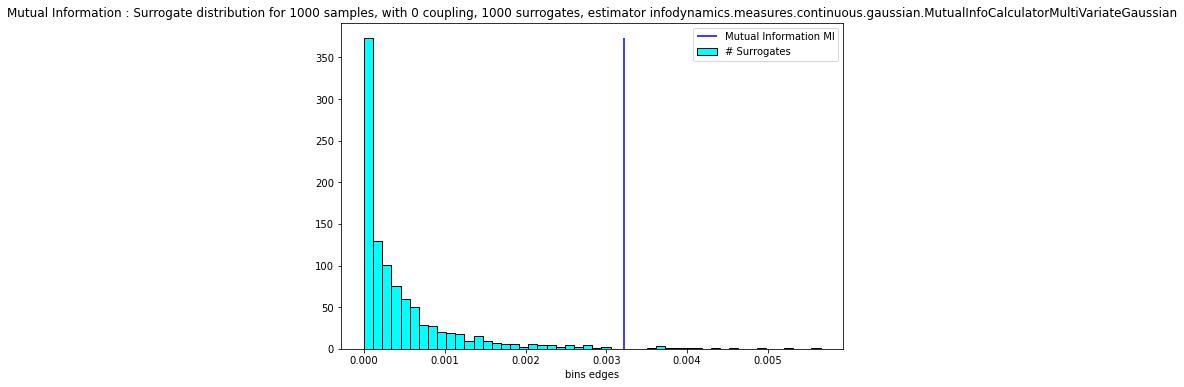

In [16]:
source, destination = setupData(1000, 1000, 0.05)
result4, calc4, calcClass4, distribution4 = calcGaussianMI(source, destination)
print(distribution4.shape)

print('Mutual Information calculated:{:.6f}'.format(result4) )

plotHist(distribution4, result4, 'cyan', calcClass4.__name__)

In [17]:
def iterateMI(iters, N, S, coupling):
    results=[]
    distributions=[]

    for i in range(iters):

        source, destination = setupData(N, S, coupling)
        result, calc, calcClass, distribution = calcGaussianMI(source, destination)
        results.append(result)
        distributions.append(distribution)
        
    return np.array(distributions), np.array(results), calc, calcClass

In [18]:
distributions, results, calc, calcClass = iterateMI(100, 1000, 1000, 0.05)

In [19]:
print(distributions.shape)
distribution = np.average(distributions, axis=0)
print(distribution.shape)
result = np.average(results)

(100, 1000)
(1000,)


# BELOW : Gaussian looking stuff : THIS is somehow wrong, check bin size / and or the way I have done that average

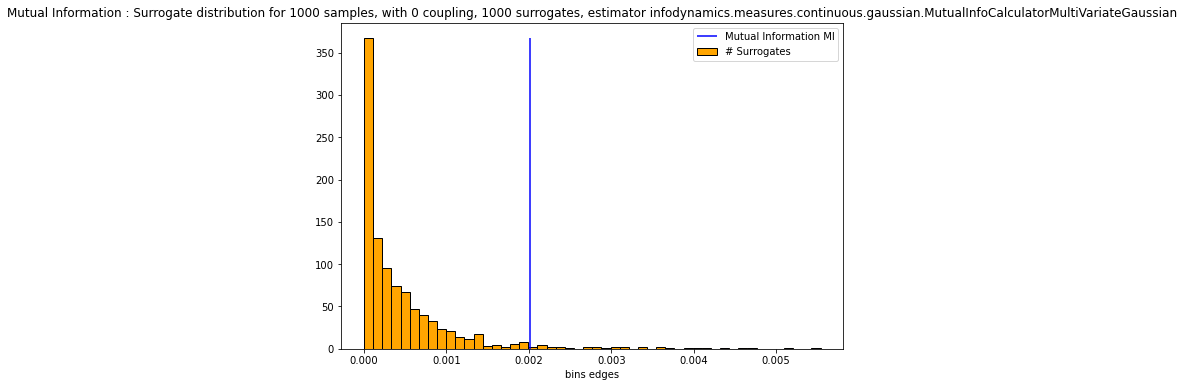

In [20]:
plotHist(distributions[0], result, 'orange', calcClass4.__name__)

## 14 With KSG Estimator

Switch back to N=1000; samples and change the calculator type to KSG (algorithm 1).    
You might want to generate new code to see how to construct this estimator, and then paste the constructor line into your current script.    
See how this changes the surrogate distribution:    

Compare the means of the surrogate distributions (notice where the KSG surrogate distribution is centred), and relate this to the KSG estimator having bias correction. (The negative values are not incorrect, they simply reflect a value smaller than the expected bias).


#### answer

Compare the standard deviations of the surrogate distributions. What factors might contribute to their difference?


#### answer

So there are more deviations in the KSG because it picks up more than guassian, it picks up non linear as well. model agnostic. So the variance is larger ... so sometimes it has a harder time finding small relationships.
The gaussian estimator was better at finding 0.05 coupling for a limited number of samples.
The gaussian estimator is designed to find linear relationships so it does that easier. The Kraskov takes more time and more samples for finding the same thing.




In [24]:
def calcMI(calculatorName, source, destination, S):

    # 1. Construct the calculator:
    calcClass=None
    if calculatorName=="gaussian":
        calcClass = JPackage("infodynamics.measures.continuous.gaussian").MutualInfoCalculatorMultiVariateGaussian
    if calculatorName=="kraskov":
        calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov1

    calc = calcClass()
    # 2. Set any properties to non-default values:
    # No properties were set to non-default values
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.setObservations(source, destination)
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    # 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
    measDist = calc.computeSignificance(S)


    # Building histogram

    distribution = np.array(measDist.distribution)
    return result, calc, calcClass, distribution

In [27]:
def iterateWithCalculatorMI(calculatorName, iters, N, S, coupling):
    results=[]
    distributions=list(np.zeros(N*iters))

    for i in range(iters):

        source, destination = setupData(N, S, coupling)
        result, calc, calcClass, distribution = calcMI(calculatorName, source, destination, S)
        results.append(result)
        distributions.append(distribution)
        
    return np.array(distributions), np.array(results), calc, calcClass

In [28]:

distributions, results, calc, calcClass = iterateWithCalculatorMI("kraskov", 1, N=1000, S=1000, coupling=0.05)

/tmp/ipykernel_26332/2589605952.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(distributions), np.array(results), calc, calcClass


(1001,)
(1000,)


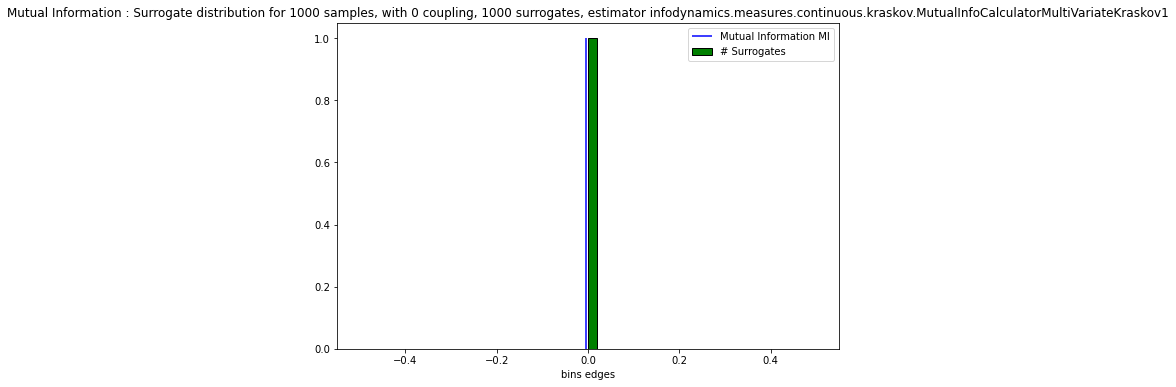

In [29]:
print(distributions.shape)
distribution = np.average(distributions, axis=0)
print(distribution.shape)
result = np.average(results)
plotHist(distributions[0], result, 'green', calcClass.__name__)

/tmp/ipykernel_26332/2589605952.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(distributions), np.array(results), calc, calcClass


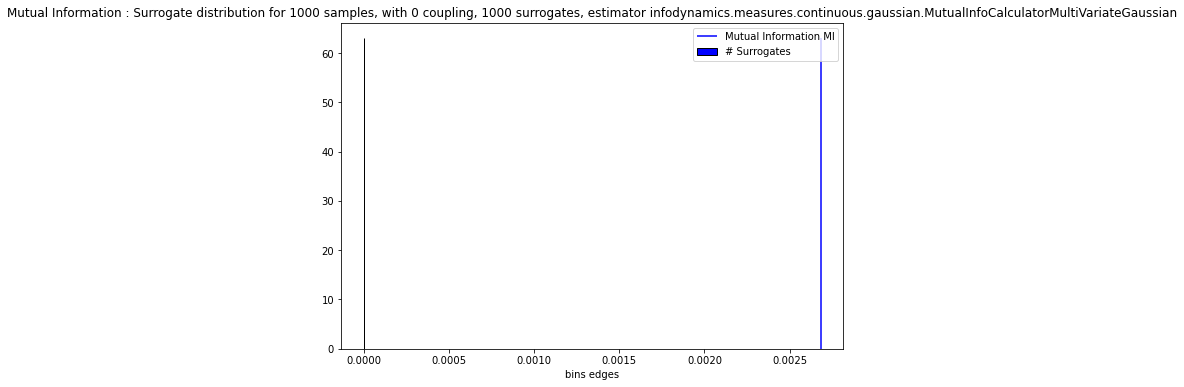

In [30]:
distributions, results, calc, calcClass = iterateWithCalculatorMI("gaussian", 10, N=1000, S=1000, coupling=0.05)

distribution = np.average(distributions, axis=0)

result = np.average(results)
plotHist(distribution, result, 'blue', calcClass.__name__)